## **Proyecto de aula**

Fundamentos en programación para Ciencia de Datos

Universidad de Antioquia


**Julieth Tatiana García Zuluaga -
Natalia López Grisales -
Melissa Ortega Alzate**

19 de agosto 2023



<div style="text-align: right;">
    <img src="https://www.paho.org/sites/default/files/fact-sheet-breastcancer2018-spa-image1_0.png" width="450px">
</div>

Figura 1. Estadísticas cáncer de mama en América (OPS) [1].

Entre los tres pilares implementados por la OPS, se encuentra **el diagnóstico oportuno**, para que las mujeres sean referidas a los servicios de diagnóstico en el momento apropiado [1].


---

# 1 Tratamiento de datos

Para el desarrollo del proyecto se utilizó el dataset "Breast Cancer Wisconsin (Diagnostic) [2].


No se modifica, combina o utiliza el dataset con propósitos comerciales.

# 2 Objetivo

Entrenar un modelo de clasificación para predecir el diagnóstico de cáncer de mama a partir de las características de células mamarias.

# 3 Análisis exploratorio de datos

## 3.1 Descripción del conjunto de datos

Cada columna del data set representa una característica de los núcleos celulares presentes en alguna muestra de tejido que permiten para cuantificar y describir ciertos aspectos de las célula.

Estas caracteristicas se calculan a partir de una imagen digitalizada de una masa mamaria como la de la figura 2.

Según esta imágen...**¿las células presentes son benignas o malignas?**

<img src="https://www.researchgate.net/profile/Nick-Street/publication/2512520/figure/fig1/AS:279373195300875@1443619168750/Initial-Approximate-Boundaries-of-Cell-Nuclei-The-user-rst-draws-a-rough-initial-outline.png" width="500px">


Figura 2. Imágen digitalizada de núcleos celulares [3].

### Atributos

1. id
2. Diagnosis (M = malignant, B = benign)

A partir de cada imágen, se calcularon diez características:

1. Radio (promedio de las distancias desde el centro hasta los puntos en el perímetro)
2. Textura (desviación estándar de los valores de escala de grises de 0 a 255)
3. Perímetro
4. Área
5. Suavidad (variación local en las longitudes del radio. Puede reflejar la textura y la regularidad de la superficie celular.)
6. Compacidad (perímetro^2 / área - 1)
7. Concavidad (mide la severidad de las porciones cóncavas del contorno)
8. Puntos cóncavos (número de porciones cóncavas del contorno)
9. Simetría
10. Dimensión fractal ("aproximación de la línea costera" - 1)

Se calculó el promedio, el error estándar y el "peor" (promedio de los tres valores más grandes) de estas características para cada imagen, lo que resulta en 30 características.

Por ejemplo, el campo 3 es radio promedio, el campo 13 es radio SE, el campo 23 es peor radio.

### Cargar librerías

In [23]:
# Import data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import models from scikit learn module
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

### Cargar conjunto de datos

In [24]:
# Loading the dataset
input_data = pd.read_csv("https://raw.githubusercontent.com/TatianaGarcia1128/archivos/main/data.csv")
input_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [25]:
# Dataframe information
input_data.info(verbose= False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Columns: 33 entries, id to Unnamed: 32
dtypes: float64(31), int64(1), object(1)
memory usage: 146.8+ KB


El data set tiene 569 instancias y 33 columnas, de las cuáles 31 son de tipo float64, una es int(64) y una tipo object (contiene datos de tipo genérico o no numérico). Con ese número de datos y tipo de datos el DataFrame utiliza apróximadamente 146,8+ KB.

## 3.2 Preprocesamiento de datos


#### Valores faltantes

In [26]:
# Check nulls by columns
count_nan = input_data.isna().sum()

# Looking for the columns that have at least one null value
missing_values_columns = count_nan[count_nan > 0]

print(f"Las columnas con valores faltantes y su cantidad son: \n{missing_values_columns}")

Las columnas con valores faltantes y su cantidad son: 
Unnamed: 32    569
dtype: int64


La columna "Unnamed: 32" contiene sólo datos nulos, se elimina a continuación porque no presenta información relevate para las instancias.

In [27]:
# Drop column with missing values in a new DataFrame
preprocessed_data = input_data.drop(columns = missing_values_columns.index)
preprocessed_data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [28]:
# Check nulls in all dataframe
print(f"El número de valores nulos en el dataframe preprocesado es: {preprocessed_data.isnull().sum().sum()}")

El número de valores nulos en el dataframe preprocesado es: 0


#### Mapeo de la variable objetivo

In [29]:
# Check the data type of the target variable column
print(f"El tipo de datos de la variable objetivo es: {preprocessed_data['diagnosis'].dtype}")

El tipo de datos de la variable objetivo es: object


Es recomendable utilizar tipos de datos específicos y optimizados para cada columna, ya que esto influye en el rendimiento de las operaciones y facilita el uso con otras librerías y métodos [4].

In [30]:
# Reassign values using map
preprocessed_data['diagnosis'] = preprocessed_data['diagnosis'].map({'M':1,'B':0})
print(f"El tipo de dato de la variable objetivo después de reasignar los valores es: {preprocessed_data['diagnosis'].dtype}")

preprocessed_data.head(5)

El tipo de dato de la variable objetivo después de reasignar los valores es: int64


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Eliminando atributos que no aportan información relevante

In [31]:
# Dropping id column
preprocessed_data.drop(columns=['id'], inplace= True)

## 3.3 Análisis exploratorio de datos

#### Estadísticos descriptivos

In [32]:
# Exploring data
preprocessed_data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Los atributos que se refieren a las características promedio tienen escalas o magnitudes diferentes a aquellos que describen el error estándar o "worse".

El algortimo de clasificación utilizado es sensible a la diferencia de escalas que se presenta entre los atributos del DataFrame [5].

#### Distribución de la variable objetivo

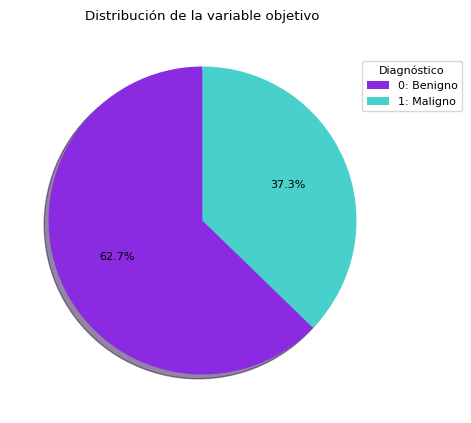

In [33]:
# Plot target variable distribution as a pie chart

# Create the figure object
fig, ax = plt.subplots(figsize= (5, 5), subplot_kw= dict(aspect="equal"))

# Create the pie chart
ax.pie(preprocessed_data['diagnosis'].value_counts(),
        autopct= '%1.1f%%',
        colors= ['blueviolet', 'mediumturquoise'],
        shadow = True,
        startangle= 90
        )

# Style the plot
legends = ['0: Benigno','1: Maligno']
ax.legend(legends,
          title="Diagnóstico",
          loc="center left",
          bbox_to_anchor=(0.9, 0.6, 0.5, 0.5))

ax.set_title("Distribución de la variable objetivo")
plt.show()

De la figura se conoce que 357 instancias tienen diganóstico benigno y 212 malignos. En este caso, se evidencia un desequilibrio en la distribución de clases, pues la mayoría de las instancias son "benignas".

#### Distribución de los atributos

In [34]:
# split dataframe into two based on diagnosis
df_M = preprocessed_data[preprocessed_data['diagnosis'] == 1]
df_B = preprocessed_data[preprocessed_data['diagnosis'] == 0]

# Create a function to plot histograms of a list of features
def plot_features(features_columns:list, preprocessed_data: pd.DataFrame, df_M:pd.DataFrame, df_B:pd.DataFrame):
    '''
    Returns the histograms plots for features variables.

            Args:
              features_columns (list): list of columns of the features dataframe. Lenght most be 10.
              preprocessed_data (pd.DataFrame): features dataframe.
              df_M (pd.DataFrame): dataframe filter for maligne.
              df_B (pd.DataFrame): dataframe filter for benigne.

            Returns:
              Plot of features histograms

            Example:
              >>> figure = plot_features(features_mean, preprocessed_data, df_M, df_B)
    '''

    # matplotlib styling parameter setting
    plt.rcParams.update({'font.size': 8})

    # Defines subplots object
    fig, axes = plt.subplots(nrows=int(len(features_columns)/2), ncols=2, figsize=(8,10))

    # Return an array of axes
    axes_ravel = axes.ravel()

    # Plot for every axes
    for idx, ax in enumerate(axes_ravel): #idx : index ,ax:ax
        min_feature_value = preprocessed_data.loc[:,features_columns[idx]].min()
        max_feature_value = preprocessed_data.loc[:,features_columns[idx]].max()
        ax.figure

        # Define width of beans for each feature
        binwidth= (max_feature_value - min_feature_value)/50

        ax.hist([df_M.loc[:,features_columns[idx]], df_B.loc[:,features_columns[idx]]],
                bins= np.arange(min_feature_value,max_feature_value + binwidth, binwidth),
                alpha= 0.5,         # Setting the opacity
                stacked= True,      # If True, multiple data are stacked on top of each other
                density = False,    # If True, the first element of the return tuple will be the counts normalized to form a probability density
                label= ['M','B'],
                color= ['mediumturquoise','blueviolet'],
                edgecolor = "black")

        # Style every ax
        ax.legend(loc= 'upper right')
        ax.set_title(features_columns[idx])

    plt.tight_layout() # Adjust the padding between and around subplots.
    plt.show()

**Mean features**

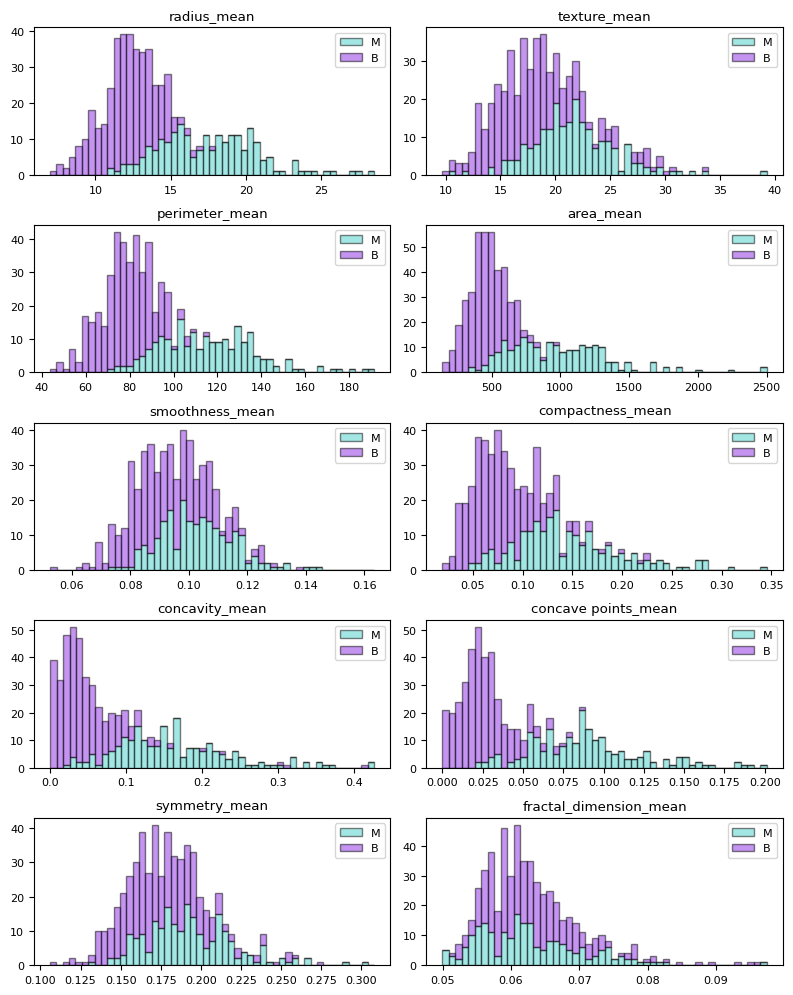

In [35]:
# Create a list of features of standard error
features_mean = list(preprocessed_data.columns[1:11])

# Plot mean features distribution
plot_features(features_mean, preprocessed_data, df_M, df_B)

**Observaciones para las características promedio**

- Los valores promedio del radio, perímetro, área, compacidad, concavidad y puntos cóncavos de las células pueden ser utilizados en la clasificación del diagnóstico de cáncer. Valores más grandes de estos parámetros tienden a mostrar una aparente correlación con el diagnóstico de tumores malignos.

- Por el contrario, los valores promedio de textura, suavidad, simetría o dimensión fractal no muestran una preferencia particular de un diagnóstico sobre el otro. En los histogramas no hay valores atípicos notables que justifiquen una limpieza adicional.


**Standars Error features**

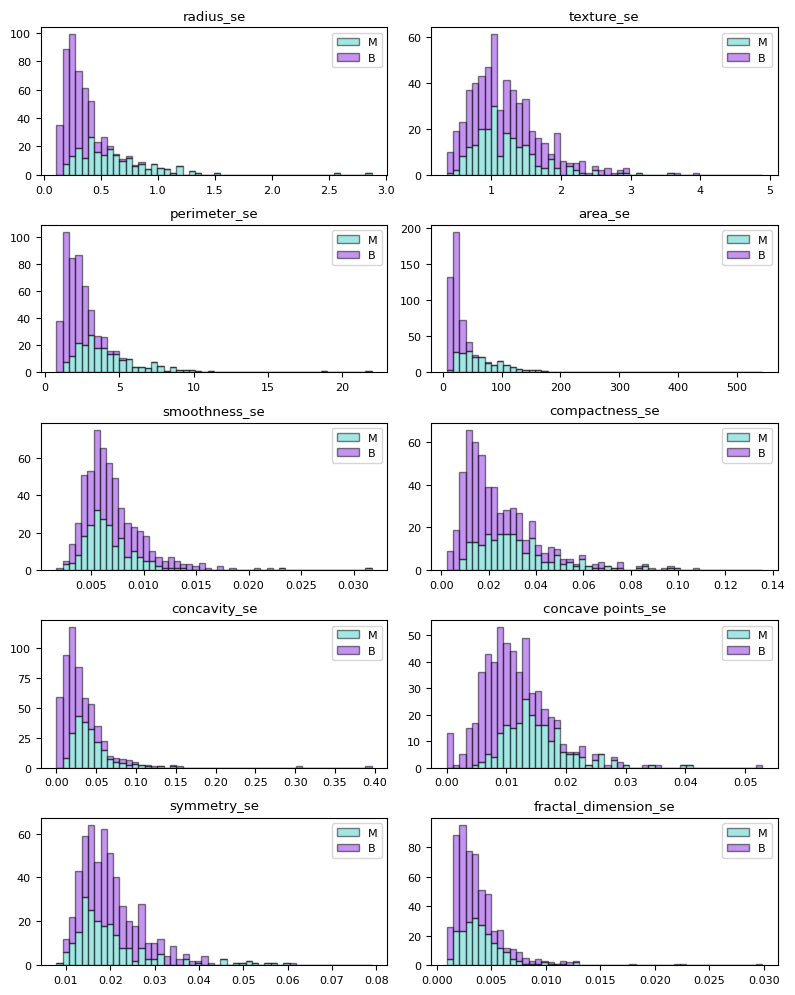

In [36]:
# Create a list of features of standard error
features_se= list(preprocessed_data.columns[11:22])

# Plot standars errors features distribution
plot_features(features_se, preprocessed_data, df_M, df_B)

**Observaciones para las características error estándar**

- Los valores de error estándar para las 10 características no muestran una preferencia particular de un diagnóstico sobre el otro.

- En todos los casos se muestran distribuciones sesgadas a la izquierda.


**Worst nucleus features**

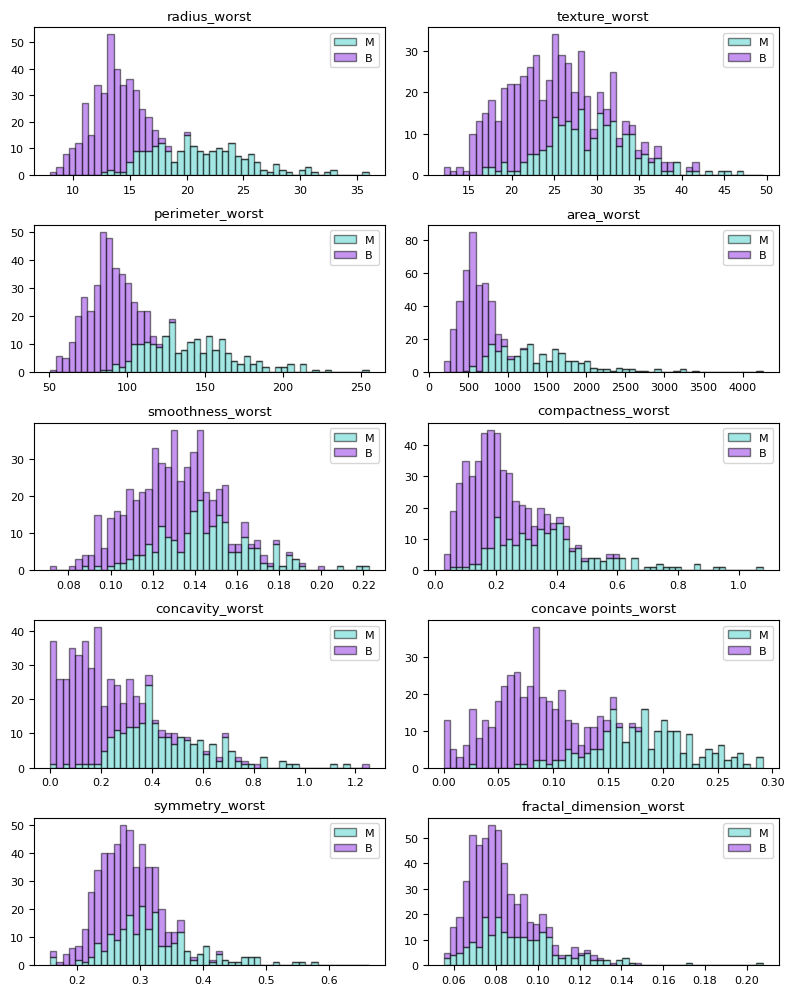

In [37]:
# Create a list of features of standard error
features_worst= list(preprocessed_data.columns[21:31])

# Plot standars errors features distribution
plot_features(features_worst,preprocessed_data, df_M, df_B)

**Observaciones para las características "peores"**

Al igual que en los valores promedio, para los "peores" (media de los tres valores mayores) los valores del radio, perímetro, área, compacidad y puntos cóncavos de las células, pueden ser utilizados en la clasificación del cáncer. Y los valores de textura, suavidad, simetría o dimensión fractal no muestran una preferencia particular de un diagnóstico sobre el otro.

#### Correlación entre los atributos


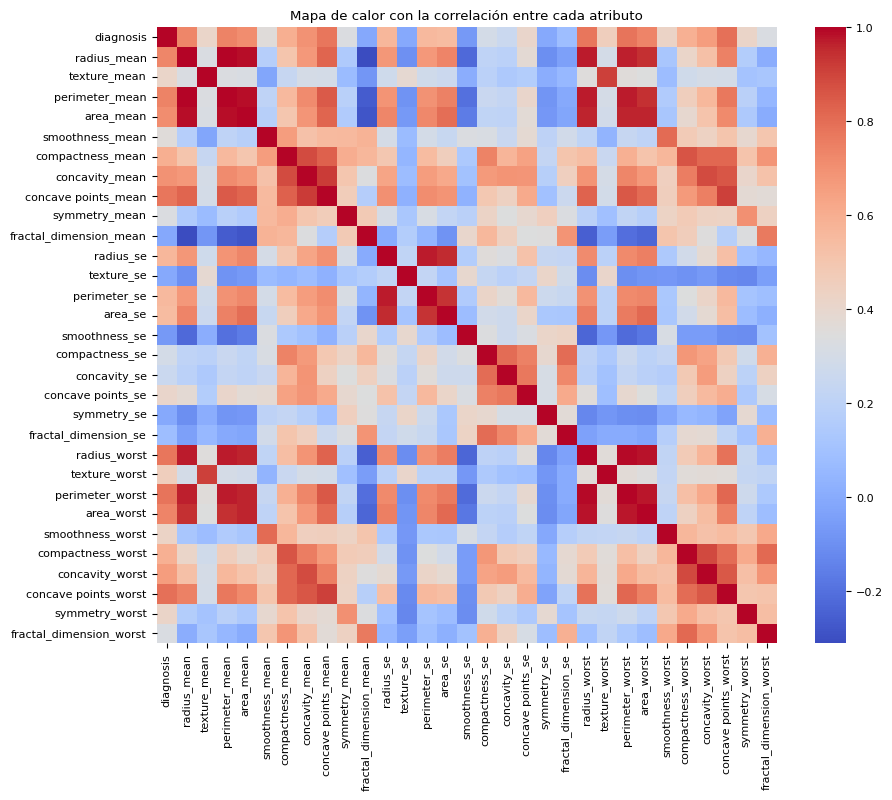

In [38]:
# Get the correlation matrix
correlation_matrix = preprocessed_data.corr()

# Create the figure object
plt.figure(figsize= (10, 8))

# Plot the correlation matrix using seaborn
sns.heatmap(correlation_matrix, annot= False, cmap='coolwarm')

# Style the figure
plt.title('Mapa de calor con la correlación entre cada atributo');

La primera columna del mapa de calor, muestra la correlación de cada atributo con el diagnóstico. Se obseva que existe una correlación positiva fuerte entre el diagnóstico y las siguientes características: radius_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean, concave points_mean, radius_worst, perimeter_worst, area_worst.

Además, es esperado que entre los atributos de radio, área y perímetro exista una correlación fuerte positiva pues son magnitudes matemáticas que se pueden calcular entre ellas.

# 4 Modelo de clasificación: Suport Vector Machine

### 4.1 Preparación del dataset

In [39]:
# Define atributes X (matrix) using .iloc to keep only the 12 selected atributes
X = preprocessed_data.loc[:,['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean'
                              ,'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst','compactness_worst'
                              , 'concavity_worst','concave points_worst']]

# Define the labels y (vector) using .iloc
y = preprocessed_data.iloc[:,0]

# Standard scaler for value normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verify the scaler
print(f"La desviación estándar de la columna 2 escalada es: {X_scaled[:,1].std()}")
print(f"El promedio de la columna 2 escalada es: {int(X_scaled[:,1].mean())}")


La desviación estándar de la columna 2 escalada es: 1.0
El promedio de la columna 2 escalada es: 0


- De acuerdo con la aparente separación de grupos observada en las graficas de dispersión y en la matriz de correlación presentada durante el Análisis Exploratorio de Datos, se escogen 12 atributos para entranar el algoritmo.

- Como se observo en el análisis exploratorio de datos, el rango de magnitud de los atributos difieren significativamente. Debido a que el rendimiento del algortimo SVM puede verse afectado por estas escalas [5]. Así, se escaló la matriz X de manera que cada atributo tenga una media de 0 y una desviación estándar de 1.


$$
z = \frac{{\text{{std}}}}{{x - \text{{mean}}}}
$$


### 4.2 Entrenamiento del modelo

El algoritmo encuentra el hiperplano que mejor separa los datos de diferentes las dos clases (maligno y beningo) en un espacio de alta dimensionalidad, como es el caso de los 12 atributos escogidos. Lo anterior, maximizando el margen entre las muestras más cercanas de cada clase.

<img src="https://techvidvan.com/tutorials/wp-content/uploads/sites/2/2020/05/Support-Vector-Machines-1.jpg" width="500px">


Figura 3. Esquema funcionamiento SVM.

In [40]:
# Split the values into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3)
print('Las dimensiones de los trenes de entrenamiento son: ', X_train.shape, y_train.shape)
print('Las dimensiones de los trenes de test son: ', X_test.shape, y_test.shape)

# C-Support Vector Classifier
SVC_classifier = SVC()

# Entrenando el modelo
SVC_classifier.fit(X_train, y_train)

# Prediction
y_result_SVC = SVC_classifier.predict(X_test)

Las dimensiones de los trenes de entrenamiento son:  (398, 12) (398,)
Las dimensiones de los trenes de test son:  (171, 12) (171,)


### 4.3 Evaluación del modelo

In [41]:
# metrics to determined
scoring = ['accuracy','f1','precision', 'recall']

scores = cross_validate(SVC_classifier, X_scaled, y, scoring = scoring, cv = 5)

# DataFrame to show scores serie
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall
0,0.006277,0.012168,0.912281,0.880952,0.902439,0.860465
1,0.005537,0.012720,0.929825,0.900000,0.972973,0.837209
2,0.008526,0.013949,0.973684,0.962963,1.000000,0.928571
3,0.007759,0.011218,0.956140,0.938272,0.974359,0.904762
4,0.003837,0.005861,0.964602,0.952381,0.952381,0.952381


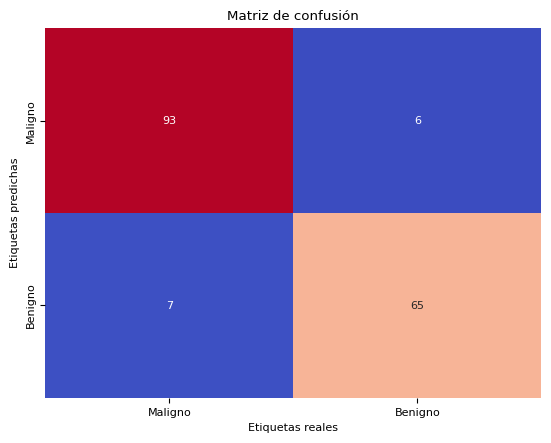

In [42]:
# Mmatriz de confusión
cm = confusion_matrix(y_test, y_result_SVC)

# Etiquetas personalizadas para ejes x e y
labels = ['Maligno', 'Benigno']

# Crear el heatmap sin la barra de color
sns.heatmap(cm,
            cmap= 'coolwarm',
            annot= True,
            fmt= 'd',
            xticklabels= labels,
            yticklabels= labels,
            cbar= False)

plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')
plt.title('Matriz de confusión')

plt.show()


- Falsos negativos (FN): casos malignos incorrectamente clasificados como benignos
- Verdaderos positivos (VP): casos malignos correctamente clasificados
- Verdaderos negativos (VN): casos benignos correctamente clasificados
- Falsos positivos (FP): casos benignos incorrectamente clasificados como malignos


In [43]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_result_SVC))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        99
           1       0.92      0.90      0.91        72

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171



# 5 Conclusiones y recomendaciones

<img src="https://img.freepik.com/free-vector/bound_53876-25486.jpg?w=740&t=st=1692420220~exp=1692420820~hmac=788f33a9d0f24bad2ec365164c0e9fc263c0fc1eaaa748bb2d398ea8f379c451" width="200px">


**Conclusiones**
- Analizar la distribución de la variable objetivo mostró que el dataset está **desbalanceado**, es decir, la mayoría de las instancias pertenecen a una clase (62.7% benigno, 37.3% maligno). Lo anterior, tiene implicaciones en el ajuste del  modelo y debe ser tenido en cuenta para la selección del algoritmo a usar.

- Al evaluar el modelo, La clase **benigno** obtuvo mejores métricas que la clase **maligno**, lo cual puede estar relacionado con que se tienen más datos de entrenamiento para esta clase.


**Trabajo futuro**
- Con el propósito de mejorar el rendimiento del modelo presentado, se sugire balancear el dataset previo a su uso.

- Se sugiere implementar un análisis de componentes principales (PCA), para seleccionar los atributos más significativos, pues durante el Análisis Exploratorio de datos se encontraron atributos altamente correlacionados, que pueden aportan la misma información al modelo.

- Programar una función de predicción del diagnóstico usando el modelo entrenado. La función debería recibir como parámetros las características resultantes de la imágen digitalizada de cada muestra de células mamarias.

- Finalmente, se puede además implementar mejoras en general, como cambiar la transparencia de los histogramas en frente para visualizar con mayor claridad cuales "bins" comparten las clases.



# 6. Referencias
[1] Organización Panamericana de la Salud. Centros para el Control y la Prevención de Enfermedades. (Acceso: agosto 2023). Cáncer de Mama. Recuperado de https://www.paho.org/es/temas/cancer-mama

[2] Wolberg,William, Mangasarian,Olvi, Street,Nick, and Street,W.. (1995). Breast Cancer Wisconsin (Diagnostic). UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.


[3] Street, W.N., Wolberg, W.H., & Mangasarian, O.L. (1993). Nuclear feature extraction for breast tumor diagnosis. Electronic imaging.

[4] Documentación oficial de Pandas. Disponible en: https://pandas.pydata.org/docs/user_guide/basics.html#dtypes

[5] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.Support Vector Machines documentation (Acceso: agosto 2023). Disponbile en: https://scikit-learn.org/stable/modules/svm.html